## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [2]:
# !pip install pytorch-lightning
!pip install pytorch-lightning==1.6.4
# ! pip install --quiet "ipython[notebook]>=8.0.0, <8.12.0" "torch>=1.8.1, <1.14.0" "setuptools==67.4.0" "torchmetrics>=0.7, <0.12" "torchvision" "pytorch-lightning>=1.4, <2.0.0" "lightning>=2.0.0rc0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery 3.10.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery-connection 1.12.1 requi

In [3]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [4]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [5]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [6]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [7]:
# TODO: GAN
class GAN(pl.LightningModule):
    def __init__(self,latent_dim=100,lr = 0.0002):
        super().__init__()
        # self.automatic_optimization = False
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        # random noise
        self.validation_z = torch.randn(6,self.hparams.latent_dim)
    def forward(self,z):
        return self.generator(z)
    def adversarial_loss(self,y_hat,y):
        return F.binary_cross_entropy(y_hat,y)
    def training_step(self,batch,batch_idx,optimizer_idx):
        real_imgs, _ = batch
        # sample noise
        z = torch.randn(real_imgs.shape[0],self.hparams.latent)
        z = z.type_as(real_imgs)
        # train generator: max log(D(G(z)))
        if optimizer_idx == 0:
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)
            y = torch.ones(real_imgs.size(0),1)
            y = y.type_as(real_imgs)
            g_loss = self.adversarial_loss(y_hat,y)
            log_dict = {"g_loss":g_loss}
            return {'loss':g_loss,'progress_bar':log_dict,'log':log_dict}
        # train discriminator max log (D(x) + log(1 - D(G(z))))
        if optimizer_idx ==1:
            # how well can it label as real
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0),1)
            y_real = y_real.type_as(real_imgs)
            real_loss = self.adversarial_loss(y_hat_real,y_real)
            y_hat_fake = self.discriminator(self(z).detach())
            y_fake = torch.zeros(real_imgs.size(0),1)
            y_fake = y_fake.type_as(real_imgs)
            fake_loss = self.adversarial_loss(y_hat_fake,y_fake)
            d_loss = (real_loss+fake_loss)/2
            log_dict = {'d_loss':d_loss}
            return {'loss':g_loss,'progress_bar':log_dict,'log':log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(),lr = lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(),lr = lr)
        return [opt_g,opt_d],[]
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch ',self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
           plt.subplot(2,3,i+1)
           plt.tight_layout()
           plt.imshow(sample_imgs.detach()[i,0,:,:],cmap='gray_r',interpolation='none')
           plt.title('Generated Data')
           plt.xticks([])
           plt.yticks([])
           plt.axis('off')
        plt.show()
    # def on_epoch_end(self):
    #     self.plot_imgs()
    def on_train_epoch_end(self):
        self.plot_imgs()

In [8]:
dm = MNISTDataModule()
model = GAN()

epoch  0


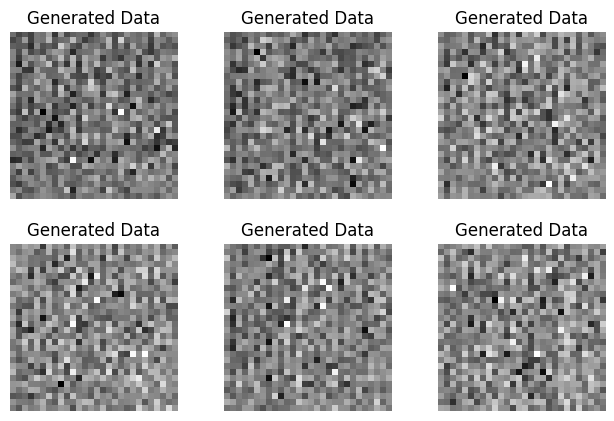

In [9]:
model.plot_imgs()

In [10]:
# trainer = pl.Trainer(max_epochs=20, devices=AVAIL_GPUS, accelerator='gpu')
trainer = pl.Trainer(max_epochs = 20,gpus= AVAIL_GPUS)
# trainer = pl.Trainer(max_epochs = 20,accelerator="gpu")
# trainer = pl.Trainer(max_epochs = 20,accelerator="auto")
trainer.fit(model,dm)
pl.Trainer()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


100%|██████████| 9912422/9912422 [00:00<00:00, 225136385.88it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42266466.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 165226638.24it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23035705.89it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

AttributeError: ignored